In [79]:
import awkward as ak
import pathlib
import numpy as np
import uproot
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, MultipleLocator, ScalarFormatter, AutoMinorLocator
from scipy.optimize import curve_fit
from scipy import stats
from scipy.spatial import cKDTree
import atlas_mpl_style as ampl
ampl.use_atlas_style()
plt.style.use('seaborn-v0_8-colorblind')
#np.set_printoptions(threshold=1000)
#%matplotlib widget
#%matplotlib inline
#from codes.plotting import plot_prettier 
#plot_prettier()

In [80]:
def open_root(file_name):
    file = uproot.open(file_name)
    tree = file['Events'].arrays(library='ak')
    file.close()
    return tree

In [82]:
nobib_134_01 = open_root('LLPs_data/134_0.1_reco.root')
nobib_134_1 = open_root('LLPs_data/134_1_reco.root')
nobib_134_10 = open_root('LLPs_data/134_10_reco.root')
nobib_1000_01 = open_root(r'LLPs_data\1000_0.1_reco_newtest.root')
# bib_134_01 = open_root('LLPs_data/134_0.1_reco_bib.root')
# bib_134_1 = open_root('LLPs_data/134_1_reco_bib.root')
# bib_134_10 = open_root('LLPs_data/134_10_reco_bib.root')

In [86]:
which_data = nobib_1000_01
# Truth
mcp_pt = which_data['mcp_pt']
mcp_eta = which_data['mcp_eta']
mcp_phi = which_data['mcp_phi'] 
mcp_stau_pt = which_data['mcp_stau_pt']
mcp_stau_eta = which_data['mcp_stau_eta']
mcp_stau_phi = which_data['mcp_stau_phi']

status = which_data['status']
pdgid = which_data['pdgid']
mcpid = which_data['id']
prod_vertex_x = which_data['prod_vertex_x']
prod_vertex_y = which_data['prod_vertex_y']
prod_vertex_z = which_data['prod_vertex_z']
prod_time = which_data['prod_time']

# Tracks (per event)
nhits = which_data['nhits']
pixel_nhits = which_data['pixel_nhits']
inner_nhits = which_data['inner_nhits']
outer_nhits = which_data['outer_nhits']
d0 = which_data['d0']
z0 = which_data['z0']
track_pt = which_data['track_pt']
track_eta = which_data['track_eta'] #Track eta
# track_theta = which_data['track_theta']
track_phi = which_data['track_phi'] #Track phi
ndf = which_data['ndf']
chi2 = which_data['chi2']

# Hits (per event per track (double nested), so that tracks and hits have the same structure but hits have an extra nested structure)
# i.e you can do x[track_pt > 10] to get all the hits for tracks with pt > 10

x = which_data['x']
y = which_data['y']
z = which_data['z']
time = which_data['time']
corrected_time = which_data['corrected_time']
hit_detector = which_data['hit_detector'] # 1/2 = pixel, 3/4 = inner, 5/6 = outer (barrel/endcap)
hit_layer = which_data['hit_layer'] # pixel has 8/8 layers, inner has 3/6, outer has 3/4
hit_side = which_data['hit_side'] # can be 0, -1, or 1. Perhaps this is the side of the detector

### Old Datasets

In [84]:
# Using local path, takes 10-15 seconds
#############################################################################################
# BIB
# bib_134_10 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_10_reco_bib.json"))
# bib_134_01 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_0.1_reco_bib.json"))
# bib_134_1 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_1_reco_bib.json"))
# bib_300_10 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\300_10_reco_bib.json"))

#############################################################################################
# NOBIB
# nobib_134_1 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_1_reco.json"))
# nobib_134_1_loose = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_1_reco_loose.json"))
# nobib_134_01 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_0.1_reco.json"))
# nobib_134_01_loose = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_0.1_reco_loose.json"))
# nobib_134_10 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_10_reco.json"))
# nobib_134_10_loose = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_10_reco_loose.json"))
# nobib_300_10 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\300_10_reco.json"))
# nobib_300_10_loose = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\300_10_reco_loose.json"))

#############################################################################################
# SIM+DIGI
# sim_134_01 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_0.1_sim.json"))
# sim_134_1 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_1_sim.json"))
# sim_134_10 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_10_sim.json"))
# digi_bib_134_1 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_1_digi_bib.json"))

# Using SSHFS, takes ~ 3 mins (5 mins when not plugged in)
# Run the following command in command prompt as administrator
# net use X: \\sshfs.r\lrozanov@kdplab01.uchicago.edu
# bib = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb_bib\stau_output_reco_bib.json"))
# bib_10 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb_bib\stau_output_reco_bib_10.json"))
# run_14_bib = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb_bib\run_14_reco_bib.json"))
# run_14_nobib = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb\run_14_reco.json"))
# bib_134_10 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb_bib\134_10_reco_bib.json"))
# bib_134_01 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb_bib\134_0.1_reco_bib.json"))
# bib_134_1 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb_bib\134_1_reco_bib.json"))
# bib_300_10 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb_bib\300_10_reco_bib.json"))
# nobib_134_1 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb\134_1_reco.json"))
# nobib_134_01 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb\134_0.1_reco.json"))
# nobib_134_10 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb\134_10_reco.json"))
# nobib_300_10 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb\300_10_reco.json"))
# nobib = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb\stau_output_reco.json"))
# sim = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\sim_Hbb\stau_output_sim.json"))
# run_14_sim = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\sim_Hbb\run_14_sim.json"))
# sim_134_1 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\sim_Hbb\134_1_sim.json"))
# digi = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\digi_Hbb\stau_output_digi.json"))
# digi_bib = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\digi_Hbb_bib\stau_output_digi_bib.json"))
# digi_bib_10 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\digi_Hbb_bib\stau_output_digi_bib_10.json"))
# digi_bib_134_1 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\digi_Hbb_bib\134_1_digi_bib.json"))


In [6]:
# print((bib_134_1.type.show()))
print(len(np.ravel(digi_bib_134_1['IB_x'][:10])))
print(len(np.ravel(bib_134_1['mcp_eta'])))
print(len(np.ravel(nobib_134_1['reco_IB_x'][:10])))
print(len(np.ravel(nobib_134_1['mcp_eta'])))


4999008
153392
95
154837


In [7]:
# 1 min
# nobib_134_1 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb\134_1_reco.json"))
# nobib_134_01 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb\134_0.1_reco.json"))
# nobib_134_10 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb\134_10_reco.json"))
# nobib_300_10 = ak.from_json(pathlib.Path(r"X:\local\d1\lrozanov\mucoll-tutorial-2023\reco_Hbb\300_10_reco.json"))

In [8]:
# # Truth
# mcp_pt = bib_134_1['mcp_pt']
# mcp_eta = bib_134_1['mcp_eta']
# mcp_phi = bib_134_1['mcp_phi'] 
# mcp_mu_pt = bib_134_1['mcp_mu_pt']
# mcp_mu_eta = bib_134_1['mcp_mu_eta']
# mcp_mu_phi = bib_134_1['mcp_mu_phi']

# status = bib_134_1['status']
# pdgid = bib_134_1['pdgid']
# mcpid = nobib_134_1['id']
# prod_vertex = nobib_134_1['prod_vertex']
# prod_time = nobib_134_1['prod_time']

# # Tracks (per event)
# nhits = bib_134_1['nhits']
# pixel_nhits = bib_134_1['pixel_nhits']
# inner_nhits = bib_134_1['inner_nhits']
# outer_nhits = bib_134_1['outer_nhits']
# pt_res_hits = bib_134_1['pt_res_hits']
# d0_res = bib_134_1['d0_res']
# z0_res = bib_134_1['z0_res']
# track_pt = bib_134_1['track_pt']
# pt_res = bib_134_1['pt_res'] 
# pt_match = bib_134_1['pt_match'] #THIS IS TRUTH PT for matched tracks
# eta_match = bib_134_1['eta_match'] #Truth eta
# track_eta = bib_134_1['track_eta'] #Track eta
# theta_match = bib_134_1['theta_match']
# track_phi = bib_134_1['phi_match'] #Track phi
# ndf = bib_134_1['ndf']
# chi2 = bib_134_1['chi2']

# # Hits (per event per track (double nested), so that tracks and hits have the same structure but hits have an extra nested structure)
# # i.e you can do x[track_pt > 10] to get all the hits for tracks with pt > 10

# x = bib_134_1['x']
# y = bib_134_1['y']
# z = bib_134_1['z']
# hit_pdgid = bib_134_1['hit_pdgid'] # this only works for simhits, not reco hits
# time = bib_134_1['time']
# corrected_time = bib_134_1['corrected_time']
# hit_detector = bib_134_1['hit_detector'] # 1/2 = pixel, 3/4 = inner, 5/6 = outer (barrel/endcap)
# hit_layer = bib_134_1['hit_layer'] # pixel has 8/8 layers, inner has 3/6, outer has 3/4
# hit_side = bib_134_1['hit_side'] # can be 0, -1, or 1. Perhaps this is the side of the detector



In [85]:
which_data = nobib_1000_01

# Common keys (without prefix) for both sim and reco, assuming some fields are common
common_keys = [
    "VB_x", "VB_y", "VB_z", "VB_time", "VB_layer",
    "VE_x", "VE_y", "VE_z", "VE_time", "VE_layer",
    "IB_x", "IB_y", "IB_z", "IB_time", "IB_layer",
    "IE_x", "IE_y", "IE_z", "IE_time", "IE_layer",
    "OB_x", "OB_y", "OB_z", "OB_time", "OB_layer",
    "OE_x", "OE_y", "OE_z", "OE_time", "OE_layer",
]

# Sim-specific keys
sim_specific_keys = [
    "VB_pdg", "VB_mcpid",
    "VE_pdg", "VE_mcpid",
    "IB_pdg", "IB_mcpid",
    "IE_pdg", "IE_mcpid",
    "OB_pdg", "OB_mcpid",
    "OE_pdg", "OE_mcpid",
]

# Dynamically create variables for common keys with sim_ and reco_ prefixes
for key in common_keys:
    for prefix in ["sim_", "reco_"]:
        full_key = f"{prefix}{key}"
        # Use hasattr to check if the which_data record has this key
        if hasattr(which_data, full_key):
            # Access the field directly if it exists
            globals()[full_key] = getattr(which_data, full_key)

# Dynamically create variables for sim-specific keys
for key in sim_specific_keys:
    full_key = f"sim_{key}"
    if hasattr(which_data, full_key):
        globals()[full_key] = getattr(which_data, full_key)

# Removed OE because it was weird

sim_x = np.ravel(ak.concatenate([sim_VB_x, sim_VE_x, sim_IB_x, sim_IE_x, sim_OB_x], axis=1))
sim_y = np.ravel(ak.concatenate([sim_VB_y, sim_VE_y, sim_IB_y, sim_IE_y, sim_OB_y], axis=1))
sim_z = np.ravel(ak.concatenate([sim_VB_z, sim_VE_z, sim_IB_z, sim_IE_z, sim_OB_z], axis=1))
sim_time = np.ravel(ak.concatenate([sim_VB_time, sim_VE_time, sim_IB_time, sim_IE_time, sim_OB_time], axis=1))
sim_pdg = np.ravel(ak.concatenate([sim_VB_pdg, sim_VE_pdg, sim_IB_pdg, sim_IE_pdg, sim_OB_pdg], axis=1))
sim_mcpid = np.ravel(ak.concatenate([sim_VB_mcpid, sim_VE_mcpid, sim_IB_mcpid, sim_IE_mcpid, sim_OB_mcpid], axis=1))
sim_layer = np.ravel(ak.concatenate([sim_VB_layer, sim_VE_layer, sim_IB_layer, sim_IE_layer, sim_OB_layer], axis=1))


reco_x = np.ravel(ak.concatenate([reco_VB_x, reco_VE_x, reco_IB_x, reco_IE_x, reco_OB_x], axis=1))
reco_y = np.ravel(ak.concatenate([reco_VB_y, reco_VE_y, reco_IB_y, reco_IE_y, reco_OB_y], axis=1))
reco_z = np.ravel(ak.concatenate([reco_VB_z, reco_VE_z, reco_IB_z, reco_IE_z, reco_OB_z], axis=1))
reco_time = np.ravel(ak.concatenate([reco_VB_time, reco_VE_time, reco_IB_time, reco_IE_time, reco_OB_time], axis=1))
reco_layer = np.ravel(ak.concatenate([reco_VB_layer, reco_VE_layer, reco_IB_layer, reco_IE_layer, reco_OB_layer], axis=1))

### Check for Staus

In [88]:
# print(len((nobib_134_1['mcp_pt'][0])))
# print(len(ak.flatten(digi_bib_134_1['mcp_pt'])))
choose_dataset = nobib_1000_01
counter = 0
print("Stau pT, eta, status:")
for i,id in enumerate(ak.flatten(choose_dataset['pdgid'])):
    if np.abs(id) == 1000015 or np.abs(id) == 2000015:
        counter +=1 
        # print("\t",ak.flatten(choose_dataset['mcp_pt'])[i], ak.flatten(choose_dataset['mcp_eta'])[i], ak.flatten(choose_dataset['status'])[i])
print("# of staus:", counter)
# print(len(np.ravel(choose_dataset['pdgid'][np.abs(choose_dataset[pdgid]) == 1000015])))

Stau pT, eta, status:
# of staus: 6


### [Solved; ignore] Dealing with empty elements - this is probably obsolete but I've saved the dataset to show what the problem was 

**May be duplicate/skipped hits - find a way to check if sim and reco are one to one matched by index**

**Update**: There are empty elements for both, simhits and recohits, sometimes matched, sometimes not, but overall after flattening, there are fewer elements in recohits than in simhits (seemingly more true in inner/outer than vertex)

NB: Elements of the arrays are lists. There can be more numbers in a sim list than a reco list at the same index. The issue is not necessarily from empty reco lists, but from fewer elements IN a reco list than a sim list

I think this will be solved by adding None or 0 to the reco list for when there is no related reco hit to a sim hit

**Update**: After adding None to all reco lists, it seems everything is fine except for sim_OE. sim_OE shape is very strange - double nested stuff

In [12]:
print("sim_OE type:")
print(sim_OE_x.type.show())
print(sim_OE_x[2])
print("sim_OE length:", (len(np.ravel(sim_OE_x))))
print("\n")
print("sim_OB type:")
print(sim_OB_x.type.show())
print(sim_OB_x[1])
print("sim_OB length:", len(np.ravel(sim_OB_x)))


sim_OE type:
550 * var * float32
None
[]
sim_OE length: 1107


sim_OB type:
550 * var * float32
None
[819, 1.15e+03, 1.48e+03, 819, ..., 1.49e+03, -822, -1.15e+03, -1.49e+03]
sim_OB length: 6921


In [23]:
oldnobib_134_1 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\oldnobib_134_1.json"))

# Basic keys (without prefix) common to both sim and reco
common_keys = [
    "VB_x", "VB_y", "VB_z", "VB_time", "VB_layer",
    "VE_x", "VE_y", "VE_z", "VE_time", "VE_layer",
    "IB_x", "IB_y", "IB_z", "IB_time", "IB_layer",
    "IE_x", "IE_y", "IE_z", "IE_time", "IE_layer",
    "OB_x", "OB_y", "OB_z", "OB_time", "OB_layer",
    "OE_x", "OE_y", "OE_z", "OE_time", "OE_layer",
]

# Sim-specific keys (considering PDG and MCPID may not have reco counterparts)
sim_specific_keys = [
    "VB_pdg", "VB_mcpid",
    "VE_pdg", "VE_mcpid",
    "IB_pdg", "IB_mcpid",
    "IE_pdg", "IE_mcpid",
    "OB_pdg", "OB_mcpid",
    "OE_pdg", "OE_mcpid",
]

# Dynamically create variables for common keys with sim_ and reco_ prefixes
for key in common_keys:
    for prefix in ["sim_", "reco_"]:
        full_key = f"{prefix}{key}"
        # Use hasattr to check if the oldnobib_134_1 record has this key
        if hasattr(oldnobib_134_1, full_key):
            # Access the field directly if it exists
            globals()["old_"+full_key] = getattr(oldnobib_134_1, full_key)

# Dynamically create variables for sim-specific keys
for key in sim_specific_keys:
    full_key = f"sim_{key}"
    if hasattr(oldnobib_134_1, full_key):
        globals()["old_"+full_key] = getattr(oldnobib_134_1, full_key)

### Check Sim File

In [ ]:
sim_4000_01 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\4000_0.1_sim.json"))

In [29]:
which_dataset = sim_4000_01

# Basic keys (without prefix) common to both sim and reco
common_keys = [
    "VB_x", "VB_y", "VB_z", "VB_time", 
    "VE_x", "VE_y", "VE_z", "VE_time", 
    "IB_x", "IB_y", "IB_z", "IB_time", 
    "IE_x", "IE_y", "IE_z", "IE_time", 
    "OB_x", "OB_y", "OB_z", "OB_time", 
    "OE_x", "OE_y", "OE_z", "OE_time",
    
    "VB_pdg", "VB_mcpid",
    "VE_pdg", "VE_mcpid",
    "IB_pdg", "IB_mcpid",
    "IE_pdg", "IE_mcpid",
    "OB_pdg", "OB_mcpid",
    "OE_pdg", "OE_mcpid"
]

# Dynamically create variables for sim-specific keys
for key in common_keys:
    if hasattr(which_dataset, key):
        globals()[key] = getattr(which_dataset, key)

sim_x = np.ravel(ak.concatenate([VB_x, VE_x, IB_x, IE_x, OB_x], axis=1))
sim_y = np.ravel(ak.concatenate([VB_y, VE_y, IB_y, IE_y, OB_y], axis=1))
sim_z = np.ravel(ak.concatenate([VB_z, VE_z, IB_z, IE_z, OB_z], axis=1))
sim_time = np.ravel(ak.concatenate([VB_time, VE_time, IB_time, IE_time, OB_time], axis=1))
sim_pdg = np.ravel(ak.concatenate([VB_pdg, VE_pdg, IB_pdg, IE_pdg, OB_pdg], axis=1))
sim_mcpid = np.ravel(ak.concatenate([VB_mcpid, VE_mcpid, IB_mcpid, IE_mcpid, OB_mcpid], axis=1))

41
19311


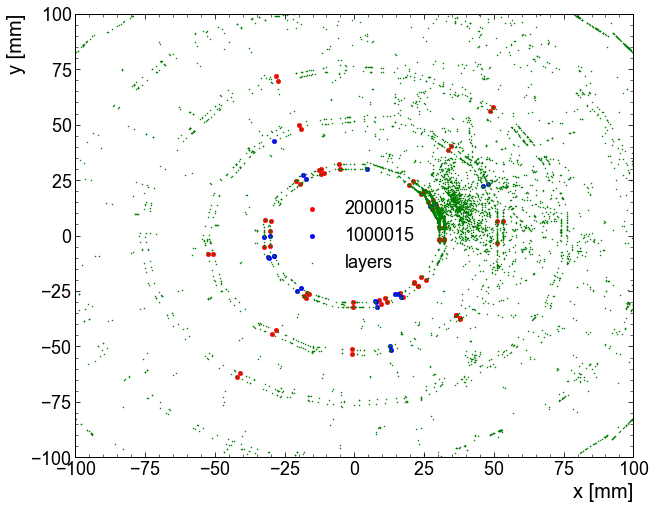

In [78]:
print(len(sim_pdg[sim_pdg == -2000015]))
print(len(sim_pdg))

# in case you know the layer positions
radii = [30, 40, 50]
theta = np.linspace(0, 2*np.pi, 500)

layers_x = np.array([])
layers_y = np.array([])

for r in radii:
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    layers_x = np.concatenate((layers_x, x))
    layers_y = np.concatenate((layers_y, y))

fig = plt.figure(figsize=(10,8))
limit = 100
limits = (-limit,limit)
plt.scatter(sim_x[np.abs(sim_pdg) == 2000015], (sim_y[np.abs(sim_pdg) == 2000015]), label = '2000015', color = 'r', s = 20)
plt.scatter(sim_x[np.abs(sim_pdg) == 1000015], (sim_y[np.abs(sim_pdg) == 1000015]), label = '1000015', color = 'b', s = 20)
plt.scatter(sim_x, sim_y,  label = 'layers', color = 'g', s = 1)
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('x [mm]', loc = 'right')
plt.ylabel(r'y [mm]', loc = 'top')
# plt.title('1000_10 Simhits 1st Event (x vs y)')
plt.legend()
plt.show()

In [15]:
print(len([x for x in reco_OE_x if len(x) < 1])/len(reco_OE_x))
# print(len(ak.flatten([x for x in reco_OE_x[reco_OE_x == None]])))
print(len(reco_OE_x))
np.set_printoptions(threshold=1000)

# print(list(sim_VB_pdg[5]))

0.8545454545454545
550


Put "old" in front of reco and sim to run over old nobib_134_1

In [16]:
def replace_empty_with_zero(array):
    empty_mask = ak.num(array) == 0
    return ak.where(empty_mask, ak.Array([[None]] * len(array)), array)

# Showing that some sim lists have more hits than reco lists
counter = 0
for i, e in enumerate(reco_VB_x):
    if len(reco_VB_x[i]) < len(sim_VB_x[i]):
        counter += 1
for i, e in enumerate(reco_VE_x):
    if len(reco_VE_x[i]) < len(sim_VE_x[i]):
        counter += 1
for i, e in enumerate(reco_IB_x):
    if len(reco_IB_x[i]) < len(sim_IB_x[i]):
        counter += 1
for i, e in enumerate(reco_IE_x):
    if len(reco_IE_x[i]) < len(sim_IE_x[i]):
        counter += 1
for i, e in enumerate(reco_OB_x):
    if len(reco_OB_x[i]) < len(sim_OB_x[i]):
        counter += 1
# all empty lists come from OE
for i, e in enumerate(reco_OE_x):
    if len(reco_OE_x[i]) < len(sim_OE_x[i]):
        counter +=0
print("The following is without OE")
print(f"There are {counter} lists with more sim than reco hits")

# This code is to show that some elements of both reco and sim are empty lists
################################################################################################################
sim_x = ak.concatenate([sim_VB_x, sim_VE_x, sim_IB_x, sim_IE_x, sim_OB_x], axis=1)
#print("Sim before modifying:", len(np.ravel(sim_x)))
VB_x_modified = replace_empty_with_zero(sim_VB_x)
VE_x_modified = replace_empty_with_zero(sim_VE_x)
IB_x_modified = replace_empty_with_zero(sim_IB_x)
IE_x_modified = replace_empty_with_zero(sim_IE_x)
OB_x_modified = replace_empty_with_zero(sim_OB_x)
OE_x_modified = replace_empty_with_zero(sim_OE_x)

# Now, concatenate the modified arrays
sim_x_modified = ak.concatenate([VB_x_modified, VE_x_modified, IB_x_modified, IE_x_modified, OB_x_modified], axis=1)
# print("Sim after modifying:", len(np.ravel(sim_x_modified)))
print("Number of empty elements in sim:", len(np.ravel(sim_x_modified)) - len(np.ravel(sim_x)))

reco_x = ak.concatenate([reco_VB_x, reco_VE_x, reco_IB_x, reco_IE_x, reco_OB_x], axis=1)
# print("Reco before modifying:", len(np.ravel(reco_x)))
reco_VB_x_modified = replace_empty_with_zero(reco_VB_x)
reco_VE_x_modified = replace_empty_with_zero(reco_VE_x)
reco_IB_x_modified = replace_empty_with_zero(reco_IB_x)
reco_IE_x_modified = replace_empty_with_zero(reco_IE_x)
reco_OB_x_modified = replace_empty_with_zero(reco_OB_x)
reco_OE_x_modified = replace_empty_with_zero(reco_OE_x)
reco_x_modified = ak.concatenate([reco_VB_x_modified, reco_VE_x_modified, reco_IB_x_modified, reco_IE_x_modified, reco_OB_x_modified], axis=1)
# print("Reco after modifying:", len(np.ravel(reco_x_modified)))
print("Number of empty elements in reco:", len(np.ravel(reco_x_modified)) - len(np.ravel(reco_x)))

The following is without OE
There are 0 lists with more sim than reco hits
Number of empty elements in sim: 923
Number of empty elements in reco: 923


### Match MCPs to simhits $\rightarrow$ recohits

In [94]:
which_data = nobib_1000_01

# Particle types of interest
electron = 11
tau = 15
stau = 2000015
# Arrays to store information about hits produced by electrons or taus
electron_hits_info = []
tau_hits_info = []
stau_hits_info = []

# Flattened arrays from your data
pdgids = np.ravel(which_data['pdgid'])
mcp_ids = np.ravel(which_data['id'])

# Additional properties
pts = np.ravel(which_data['mcp_pt'])
etas = np.ravel(which_data['mcp_eta'])
phis = np.ravel(which_data['mcp_phi'])
prod_vertex = np.concatenate([which_data['prod_vertex_x'], which_data['prod_vertex_y'], which_data['prod_vertex_z']], axis=1)

# Create a mapping from mcpid to index and pdgid for quick lookup
mcpid_to_index = {mcp_id: (i, pdgid) for i, (mcp_id, pdgid) in enumerate(zip(mcp_ids, pdgids))}

# Create a mapping from simid to ALL indexes (one particle can have multiple hits)
simid_to_indexes = {}
for i, sim_id in enumerate(np.ravel(sim_VB_mcpid)):
    if sim_id not in simid_to_indexes:
        simid_to_indexes[sim_id] = [i]
    else:
        simid_to_indexes[sim_id].append(i)
        
# Iterate over VB MCP IDs to filter and collect data based on particle type
for mcpid in sim_mcpid:
    if mcpid in mcpid_to_index:
        idx, pdgid = mcpid_to_index[mcpid]
        # Filter for electrons
        if np.abs(pdgid) == electron:
            electron_hits_info.append((pts[idx], etas[idx], phis[idx]))
        # Filter for taus
        elif np.abs(pdgid) == tau:
            tau_hits_info.append((pts[idx], etas[idx], phis[idx]))
        elif np.abs(pdgid) == stau:
            stau_hits_info.append((pts[idx], etas[idx], phis[idx]))

if stau_hits_info:
    print("Stau hits info:")
    print(stau_hits_info[0])
else:
    print("No stau hits found")
num_hits = len(mcp_ids)
# Finding recohit from MCP
for pdgid,mcp_id in zip(pdgids[:num_hits], mcp_ids[:num_hits]):
    if np.abs(pdgid) == 2000015 and mcp_id in simid_to_indexes:
        for i in simid_to_indexes[mcp_id]:
            print("MCP PDGID:", pdgid)
            # print("MCP PDGID:", pdgid, "\nReco hit:", reco_VB_x[i], reco_VB_y[i], reco_VB_z[i], reco_VB_time[i], "\nSim hit:", sim_VB_x[i], sim_VB_y[i], sim_VB_z[i], sim_VB_time[i])
        

# print("Electron hits info:", electron_hits_info)

Stau hits info:
(4259.3076, -0.5414175, -2.617231)
MCP PDGID: -2000015
MCP PDGID: -2000015
MCP PDGID: -2000015
MCP PDGID: -2000015
MCP PDGID: -2000015
MCP PDGID: -2000015
MCP PDGID: -2000015
MCP PDGID: -2000015
MCP PDGID: 2000015
MCP PDGID: 2000015
MCP PDGID: 2000015
MCP PDGID: 2000015
MCP PDGID: 2000015
MCP PDGID: 2000015
MCP PDGID: 2000015
MCP PDGID: 2000015
MCP PDGID: -2000015
MCP PDGID: -2000015
MCP PDGID: -2000015
MCP PDGID: -2000015


In [18]:
print("Total hits (on track); d0 > 1 mm, pT > 1 GeV:")
for which_data in [nobib_134_01, nobib_134_1, nobib_134_10]: 
    pt_cut = 1
    d0_cut = 1
    pt_mask = (which_data['track_pt'] > pt_cut)
    # vb_mask = (which_data['hit_detector'] == 1)
    d0_mask = (which_data['d0'] > d0_cut)
    mask = pt_mask & d0_mask
    print(len(np.ravel(which_data['track_pt'])), len(np.ravel(which_data['track_pt'][mask])))

Total hits (on track); d0 > 1 mm, pT > 1 GeV:
1349 2
1345 0
1406 4


### hit_layer is layer of detector, hit_detector is detector

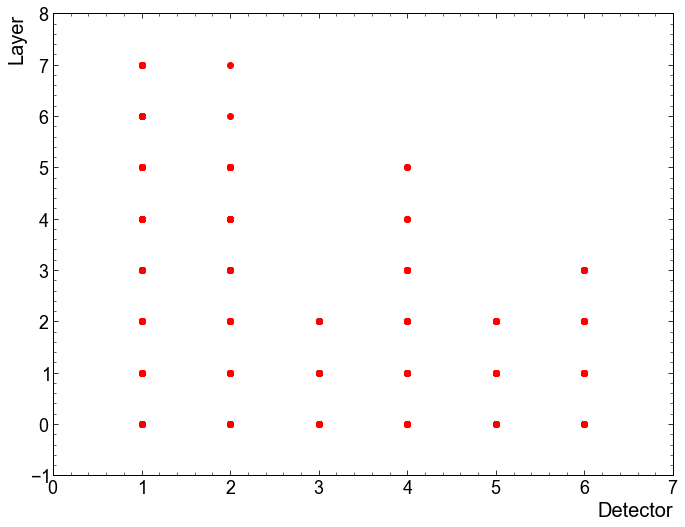

[30.3, 30.3, 30.3, 30.2, 30.2, 30.2, ..., 30.2, 30.4, 30.8, 30.4, 30.3, 30.2]


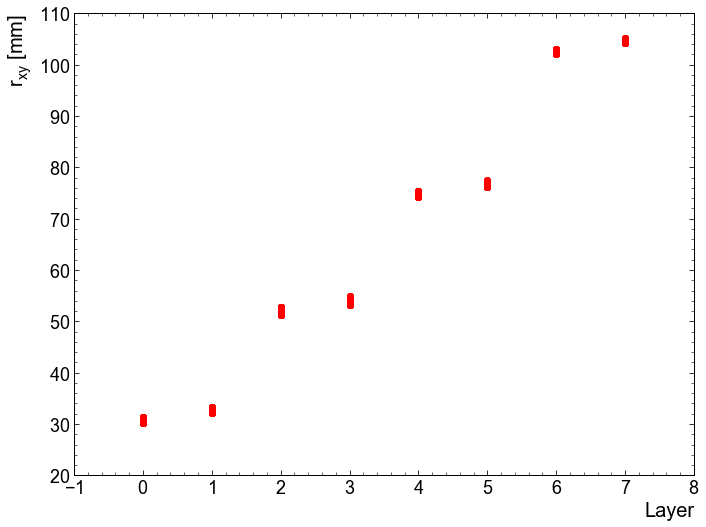

In [19]:
plt.plot(np.ravel((hit_detector)), np.ravel(hit_layer), 'ro')
plt.xlabel('Detector', loc = 'right')
plt.ylabel('Layer', loc = 'top')
plt.show()
run_14_bib = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\run_14_reco_bib.json"))
which_data = run_14_bib

r_xy = ak.flatten(np.sqrt((which_data['x'])[(which_data['hit_detector']) == 1]**2 + (which_data['y'])[(which_data['hit_detector']) == 1]**2))
print(r_xy)

plt.plot(ak.flatten((which_data['hit_layer'])[(which_data['hit_detector']) == 1]), (r_xy), 'ro')
#plt.ylim(0,100)
plt.xlabel('Layer', loc = 'right')
plt.ylabel('$r_{xy}$ [mm]', loc = 'top')
plt.show()

In [20]:
print(len(ak.flatten(nobib_134_1['track_pt'][(nobib_134_1['track_pt']>100) & (nobib_134_1['d0']<1)])))
print(len(ak.flatten(nobib_134_1['track_pt'])))

1059
1345


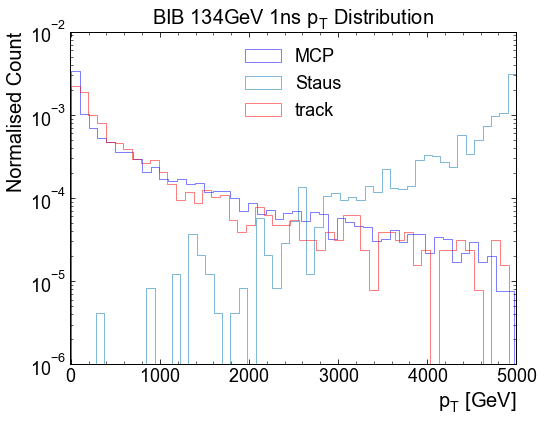

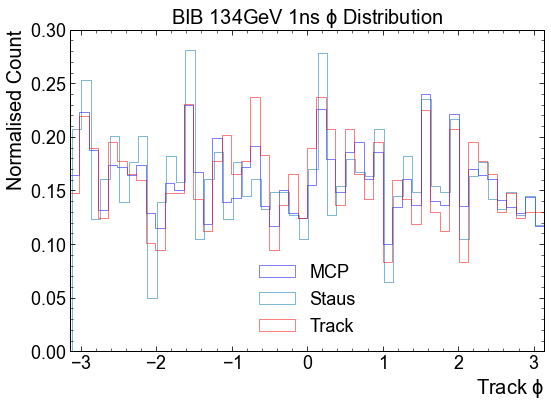

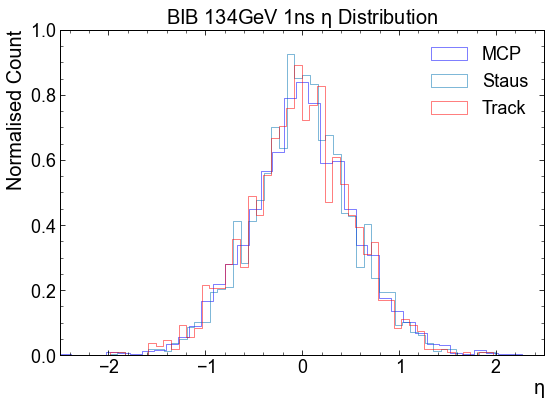

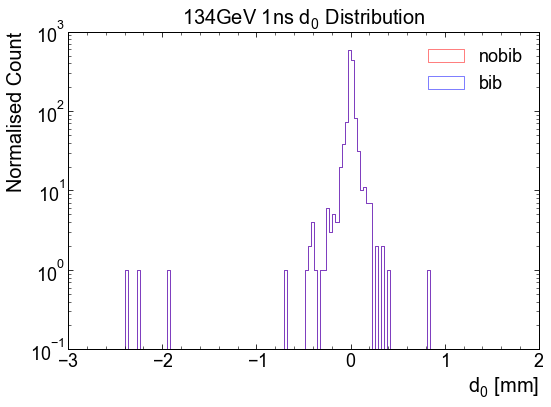

In [21]:
which_data = nobib_134_1

plt.figure(figsize=(8,6))
plt.hist(ak.flatten(which_data['mcp_pt'][which_data['status'] == 1]), bins=50, label = "MCP", color='blue', histtype = 'step', density = True)
plt.hist(ak.flatten(which_data['mcp_pt'][np.abs(which_data['pdgid']) == 1000015]), bins=50, label = "Staus", histtype = 'step', density = True)
plt.hist(ak.flatten(which_data['track_pt'][which_data['track_pt']<5000]), bins=50, label = "track", color='red',  histtype = 'step', density = True)
plt.xlim(-10,5000)
plt.xlabel('$p_T$ [GeV]', loc = 'right')
plt.ylabel('Normalised Count', loc = 'top')
plt.title('BIB 134GeV 1ns $p_T$ Distribution')
plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))

# Histogram for track phi
plt.hist(ak.flatten(which_data['mcp_phi'][which_data['status'] == 1]), bins=50, histtype='step', density = True, color='blue', label='MCP')
plt.hist(ak.flatten(which_data['mcp_phi'][np.abs(which_data['pdgid']) == 1000015]), bins=50, label = "Staus", histtype = 'step', density = True)
plt.hist(ak.flatten(which_data['track_phi']), bins=50, histtype='step', density = True, color='red', label='Track')
plt.xlim(-np.pi,np.pi)
plt.xlabel(r'Track $\phi$', loc = 'right')
plt.ylabel('Normalised Count', loc = 'top')
plt.title(r'BIB 134GeV 1ns $\phi$ Distribution')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))

# Histogram for track eta
plt.hist(ak.flatten(which_data['mcp_eta'][which_data['status'] == 1]), bins=(np.linspace(-3,3,50)), histtype='step', density = True, color='blue', label='MCP')
plt.hist(ak.flatten(which_data['mcp_eta'][np.abs(which_data['pdgid']) == 1000015]), bins=50, label = "Staus", histtype = 'step', density = True)
plt.hist(ak.flatten(which_data['track_eta']), bins=50, histtype='step', density = True, color='red', label='Track')
plt.xlim(-2.5,2.5)
plt.xlabel(r'$\eta$', loc = 'right')
plt.ylabel('Normalised Count', loc = 'top')
plt.title(r'BIB 134GeV 1ns $\eta$ Distribution')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))

# Histogram for track eta
plt.hist(ak.flatten(which_data['d0']), bins=100, histtype='step', density = False, color='red', label='nobib')
plt.hist(ak.flatten(which_data['d0']), bins=100, histtype='step', density = False, color='blue', label='bib')
#plt.xlim(-2.5,2.5)
plt.xlabel(r'$d_0$ [mm]', loc = 'right')
plt.ylabel('Normalised Count', loc = 'top')
plt.yscale('log')
plt.title(r'134GeV 1ns $d_0$ Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
print(len(np.ravel(nobib_134_01['d0'][np.abs(nobib_134_01['d0'])>1])))
print(len(np.ravel(nobib_134_01['d0'][nobib_134_01['track_pt']>100])))
print(len(np.ravel(nobib_134_01['d0'])))
print(len(nobib_134_01['d0']))

5
1059
1349
560


### Plotting Functions

In [23]:
##############################################################################################################################################################################################################################
# 2D Histogram plotting function
def plot2DHistogram(datax, datay, bins=100, weights = None, norm="log", label="", xlim = None, ylim = None, stats = False):
    """
    Plot a 2D histogram.

    Parameters:
        datax (numpy.ndarray): x-data array.
        datay (numpy.ndarray): y-data array.
        bins (int, optional): Number of bins for the 2D histogram. Default is 100.
        weights (numpy.ndarray, optional): Weights for the histogram. Default is None.
        norm (str, optional): Normalization for the color map. Default is "log".
        label (str, optional): Plot labels (title, xlabel, ylabel), split by semicolons. Default is an empty string.
        xlim (tuple, optional): X-axis limits. Default is None.
        ylim (tuple, optional): Y-axis limits. Default is None.
        stats (bool, optional): Display statistics. Default is False.
    """
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    
    if weights is not None:
        values = np.array(np.ravel(weights)).T
    else:
        values = None

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)

    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, weights = values, norm=norm, cmap="viridis")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, loc = 'right', fontsize=18)
    ax.set_ylabel(ylabel, loc = 'top', fontsize=18)
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    if stats == True:
        # Calculate statistics
        num_entries = len(data_flatx)
        mean_x = np.mean(data_flatx)
        mean_y = np.mean(data_flaty)
        std_x = np.std(data_flatx)
        std_y = np.std(data_flaty)
        # Calculate FWHM of datay
        #fwhm_value = fwhm(data_flaty, bins = np.linspace(np.min(data_flaty), np.max(data_flaty), bins[1]))
        
        # Create a text box to display statistics
        # stats_text = 'FWHM '+ylabel+f':{fwhm_value:.3f}'#"Entries: {num_entries}\nMean x: {mean_x:.2f}\nMean y: {mean_y:.2f}\nStd Dev x: {std_x:.2f}\nStd Dev y: {std_y:.2f}"
        # ax.text(0.5, 0.98, stats_text, transform=ax.transAxes, va='top', ha='left', bbox=dict(boxstyle='round, pad=0.5', facecolor='white', alpha=0.8), fontsize = 7)

    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel)#, fontsize=6)

    plt.show()

##############################################################################################################################################################################################################################
# 2D Scatter plot function
def plot2Dscatter(datax, datay, label_numbers=None, xlim=None, ylim=None, labels=""):
    """
    Plot a scatter plot with the option to label each data point with numbers.

    Parameters:
        data_x (numpy.ndarray): x-data array.
        data_y (numpy.ndarray): y-data array.
        label_numbers (numpy.ndarray, optional): Array of numbers for labeling each data point. Default is None.
        xlim (tuple, optional): X-axis limits. Default is None.
        ylim (tuple, optional): Y-axis limits. Default is None.
        labels (str, optional): Plot labels (title, xlabel, ylabel), split by semicolons. Default is an empty string.
        show_stats (bool, optional): Display statistics. Default is False.
    """
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    
    if label_numbers is not None:
        label_numbers = np.array(np.ravel(label_numbers)).T
    else:
        values = None

    fig, ax = plt.subplots(figsize=(4.5, 3))

    scatter = ax.scatter(data_flatx, data_flaty, c='blue', s=20)

    title = "" if len(labels.split(";")) < 1 else labels.split(";")[0]
    x_label = "" if len(labels.split(";")) < 2 else labels.split(";")[1]
    y_label = "" if len(labels.split(";")) < 3 else labels.split(";")[2]

    ax.set_title(title)
    ax.set_xlabel(x_label, loc='right')
    ax.set_ylabel(y_label, loc='top')

    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    if label_numbers is not None:
        # Annotate each point with its number label
        for num, x, y in zip(label_numbers, data_flatx, data_flaty):
            ax.annotate(str(num), (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
    #plt.legend()
    plt.show()

##############################################################################################################################################################################################################################
# 1D Histogram comparison function
colors = []
def compare1DHistograms(datas,bins,scale='linear',label="",leg=[]):
    """
    Compare multiple 1D histograms.

    Parameters:
        datas (list of numpy.ndarray): List of data arrays to compare.
        bins (int): Number of bins for the histograms.
        scale (str, optional): Y-axis scale. Default is 'linear'.
        label (str, optional): Plot label. Default is an empty string.
        leg (list of str, optional): Legend labels for each data series. Default is an empty list.
    """
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    
    for i,data in enumerate(datas): 
        if len(data) != 0:
            # handle data, there must be a smarter way to do this...
            if type(data[0])==np.int64   : data_flat=data
            elif type(data[0])==np.float32 : data_flat=data
            else : data_flat = ak.flatten(data, axis=None)
            
            ax.hist(data_flat, bins, alpha=1, label=leg[i] if len(leg)>i else "", histtype = 'step')
        else:
            print("No data for histogram",i)
            continue
   
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, loc = 'right', fontsize=18)
    ax.set_ylabel(ylabel,loc = 'top', fontsize=18)
    plt.legend()
    plt.yscale(scale)
    plt.show()

In [24]:

# plot2Dscatter((mcp_eta[0][status[0] == 1]), (mcp_phi[0][status[0] == 1]), label_numbers = (pdgid[0][status[0] == 1]), labels=r"MCPs w/ BIB;$\eta$;$\phi$", xlim = (-5,5), ylim = (-3.5,3.5))
# plot2Dscatter((nobib_134_01['mcp_eta'][0][nobib_134_01['status'][0] == 1]), (nobib_134_01['mcp_phi'][0][nobib_134_01['status'][0] == 1]), label_numbers = (nobib_134_01['pdgid'][0][nobib_134_01['status'][0] == 1]), labels=r"MCPs w/o BIB;$\eta$;$\phi$", xlim = (-5,5), ylim = (-3.5,3.5))



## Time Studies

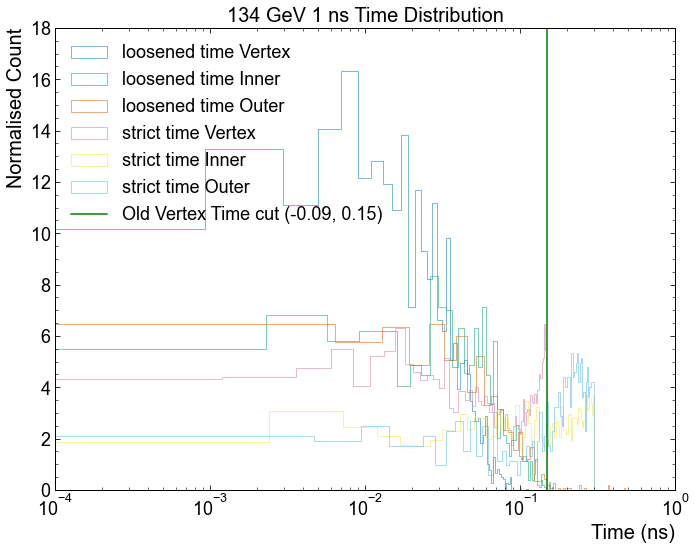

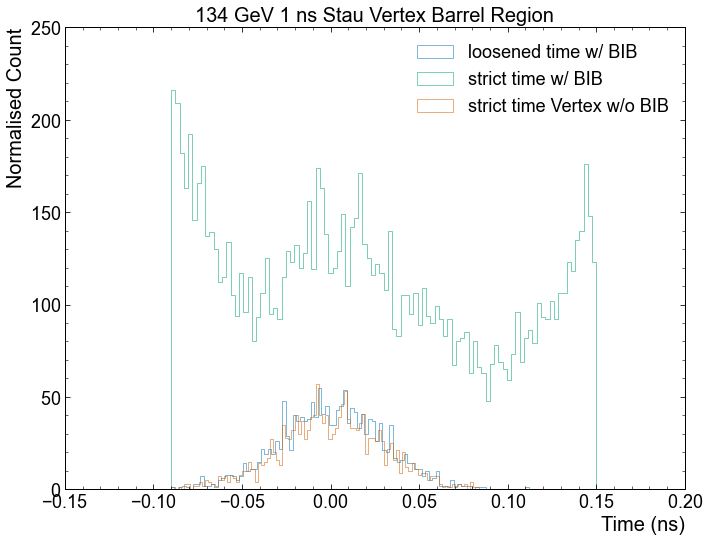

In [25]:
#import mplhep as hep
#hep.style.use("CMS")
# np.linspace(-1, 10, 120)
plt.hist(np.ravel(time[hit_detector == 1]), bins = 100, histtype = 'step', label = "loosened time Vertex", density=True)
plt.hist(np.ravel(time[hit_detector == 3]), bins = 100, histtype = 'step', label = "loosened time Inner", density=True)
plt.hist(np.ravel(time[hit_detector == 5]), bins = 100, histtype = 'step', label = "loosened time Outer", density=True)
plt.hist(np.ravel(run_14_bib['time'][run_14_bib['hit_detector'] == 1]), bins = 100, histtype = 'step', label = "strict time Vertex", density=True)
plt.hist(np.ravel(run_14_bib['time'][run_14_bib['hit_detector'] == 3]), bins = 100, histtype = 'step', label = "strict time Inner", density=True)
plt.hist(np.ravel(run_14_bib['time'][run_14_bib['hit_detector'] == 5]), bins = 100, histtype = 'step', label = "strict time Outer", density=True)
plt.axvline(x=(-0.09), color = 'green')
plt.axvline(x=(0.15), color = 'green', label = "Old Vertex Time cut (-0.09, 0.15)")
plt.xlabel("Time (ns)", loc = "right")
plt.ylabel("Normalised Count", loc = "top")
plt.xscale('log')
plt.title('134 GeV 1 ns Time Distribution')
plt.legend()
plt.show()

run_14_nobib = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\run_14_reco.json"))

plt.hist(np.ravel(time[hit_detector == 1][:100]), bins = 100, histtype = 'step', label = "loosened time w/ BIB", density=False)
plt.hist(np.ravel(run_14_bib['time'][run_14_bib['hit_detector'] == 1][:100]), bins = 100, histtype = 'step', label = "strict time w/ BIB", density=False)
plt.hist(np.ravel(run_14_nobib['time'][run_14_nobib['hit_detector'] == 1][:100]), bins = 100, histtype = 'step', label = "strict time Vertex w/o BIB", density=False)
#plt.axvline(x=(-0.09), color = 'green')
#plt.axvline(x=(0.15), color = 'green', label = "Old Vertex Time cut (-0.09, 0.15)")
plt.xlabel("Time (ns)", loc = "right")
plt.ylabel("Normalised Count", loc = "top")
#plt.xscale('log')
plt.title('134 GeV 1 ns Stau Vertex Barrel Region')
plt.legend()
plt.show()

# plot2DHistogram(time[hit_detector == 1], track_eta, bins=100, label=r"Vertex Barrel;time [ns]; $\theta [\degrees]$", xlim = (-120,120), ylim = (-120,120))

## Pointing

### Functions

In [26]:
# Function to remove duplicate hits
def make_unique(r_xy_vb, r_xyz_vb, hits_layer):
    # Find unique rows in r_xyz_vb
    unique_rows, unique_indices = np.unique(r_xyz_vb, axis=0, return_index=True)

    # Check if the number of unique rows is less than the total number of rows
    if len(unique_rows) < len(r_xyz_vb):
        print("Duplicates found in dataset:")
        
        # Find duplicate indices
        duplicate_indices = np.setdiff1d(np.arange(len(r_xyz_vb)), unique_indices)
        print(len(duplicate_indices))
        # Print duplicate rows
        # for idx in duplicate_indices:
        #     print(idx, r_xyz_vb[idx])
    else:
        print("No duplicates found in dataset.")
    r_xyz_vb = r_xyz_vb[unique_indices]
    r_xy_vb = r_xy_vb[unique_indices]
    vertex_layer = (hits_layer[unique_indices])
    return r_xy_vb, r_xyz_vb, vertex_layer

# Function to create r_xy and r_xyz arrays for the vertex barrel region
def create_r_xy(which_data = nobib_134_1, pt_cut = 100, d0_cut = 1, decay = False):
    '''
    Returns [r_xy, z] and [x,y,z] for the vertex barrel region for a given dataset and cuts
    '''
    pt_mask = (which_data['track_pt'] > pt_cut)
    vb_mask = (which_data['hit_detector'] == 1)
    if decay:
        d0_mask = (which_data['d0'] > d0_cut)
    else:
        d0_mask = (which_data['d0'] < d0_cut)
    mask = pt_mask & vb_mask & d0_mask
    hits_x = np.ravel(which_data['x'][mask])
    hits_y = np.ravel(which_data['y'][mask])
    hits_z = np.ravel(which_data['z'][mask])
    hits_layer = np.ravel(which_data['hit_layer'][mask])
    # print(hits_x)
    r_xy_vb = np.array([[np.sqrt(a**2 + b**2), c] for a, b, c in zip(hits_x, hits_y, hits_z)])
    r_xyz_vb = np.array([[a, b, c] for a, b, c in zip(hits_x, hits_y, hits_z)])
    return make_unique(r_xy_vb, r_xyz_vb, hits_layer)

# Function to find doublet pairs
def find_doublets(r_xy_vb, r_xyz_vb, vertex_layer, num_hits = None, z_tolerance = 1):
    if num_hits is None:
        num_hits = len(r_xy_vb) # 10000 takes < 1 min, 20000 takes ~4 mins

    vertex_layer = vertex_layer[:num_hits]
    r_xyz_vb_reduced = r_xyz_vb[:num_hits]
    r_xy_vb_reduced = r_xy_vb[:num_hits]

    doublet_pairs_xyz = []
    doublet_pairs_rz = []

    for layer in range(0, max(vertex_layer), 2):  
        # Identify hits in the current and next layer
        hits_current_layer = r_xyz_vb_reduced[vertex_layer == layer]
        hits_next_layer = r_xyz_vb_reduced[vertex_layer == layer + 1]
        
        # For each hit in the current layer, find a hit in the next layer within z_tolerance
        for i, hit1 in enumerate(hits_current_layer):
            #print(i, hit1)
            # Calculate the z-distance between hit1 and all hits in the next layer
            z_distances = np.abs(hit1[2] - hits_next_layer[:, 2])
            
            # Find indices of hits in the next layer within the z_tolerance
            within_tolerance = np.where(z_distances < z_tolerance)[0]
            
            # Pair hit1 with all hits within tolerance
            for j in within_tolerance:
                hit2 = hits_next_layer[j]
                doublet_pairs_xyz.append([hit1, hit2])
                # Assuming r_xy_vb_reduced is structured similarly to r_xyz_vb_reduced, index with the same logic
                doublet_pairs_rz.append([r_xy_vb_reduced[vertex_layer == layer][i], r_xy_vb_reduced[vertex_layer == layer + 1][j]])

    # Convert lists to arrays for further processing if necessary
    doublet_pairs_xyz = np.array(doublet_pairs_xyz)
    doublet_pairs_rz = np.array(doublet_pairs_rz)
    print(f"Total pairs found from {num_hits} hits: {len(doublet_pairs_xyz)}")

    return doublet_pairs_xyz, doublet_pairs_rz

# Function to compute the cylindrical coordinates (phi) of a vector
def xy_to_phi(x, y):
    return np.arctan2(y, x)

# Function to compute the longitudinal angle (theta) between a vector and the z-axis
def xyz_to_theta(x, y, z):
    return np.arctan2(np.sqrt(x**2 + y**2), z)

# Function to compute the angular difference between two angles (in radians) with cylindrical symmetry
def angular_difference(angle1, angle2):
    diff = np.abs(angle1 - angle2)
    # Adjust the difference to be within the range [-pi, pi)
    # diff = (diff + np.pi) % (2 * np.pi) - np.pi
    return np.abs(diff)

# Function to compute the pointing angles between pairs of hits
def pointing_angles(doublet_pairs_xyz, max_theta_tolerance = 3e-3, max_phi_tolerance = 35e-3):
    d_theta_d_phi = []
    # Iterate over each pair of hits in doublet_pairs_xyz
    for pair in doublet_pairs_xyz:
        # Extract the Cartesian coordinates of the two hits
        hit1_xyz, hit2_xyz = pair
        
        # Compute the longitudinal angle (theta) and cylindrical coordinate (phi) for each hit
        theta1 = xyz_to_theta(*hit1_xyz)
        theta2 = xyz_to_theta(*hit2_xyz)
        phi1 = xy_to_phi(hit1_xyz[0], hit1_xyz[1])
        phi2 = xy_to_phi(hit2_xyz[0], hit2_xyz[1])
        
        # Compute the angular differences
        d_theta = angular_difference(theta1, theta2)
        d_phi = angular_difference(phi1, phi2)
        
        # Filter based on the maximum tolerated angles
        if d_theta <= max_theta_tolerance and d_phi <= max_phi_tolerance:
            d_theta_d_phi.append(np.array([d_theta, d_phi]))

    d_theta_d_phi = np.array(d_theta_d_phi)

    return d_theta_d_phi

# Function to plot the pointing angles
def all_pointing(which_data, **kwargs):
    # Unpack kwargs for create_r_xy specifically or adjust parameters accordingly
    r_xy_vb, r_xyz_vb, vertex_layer = create_r_xy(
        which_data, 
        pt_cut=kwargs.get('pt_cut', 100),  # Provide default values if not specified
        d0_cut=kwargs.get('d0_cut', 1),
        decay=kwargs.get('decay', False)
    )
    # Unpack kwargs for find_doublets
    doublet_pairs_xyz, doublet_pairs_rz = find_doublets(
        r_xy_vb, 
        r_xyz_vb, 
        vertex_layer, 
        num_hits=kwargs.get('num_hits', 10000),  # Provide default values if not specified
        z_tolerance=kwargs.get('z_tolerance', 1)
    )
    # Now call the revised d_theta_d_phi function with correct parameters
    d_theta_d_phi = pointing_angles( 
        doublet_pairs_xyz, 
        max_theta_tolerance=kwargs.get('max_theta_tolerance', 3e-3), 
        max_phi_tolerance=kwargs.get('max_phi_tolerance', 35e-3)
    )
    print(f"The hit survival rate: {len(d_theta_d_phi)/len(r_xy_vb)}")

    return d_theta_d_phi



Duplicates found in dataset:
145


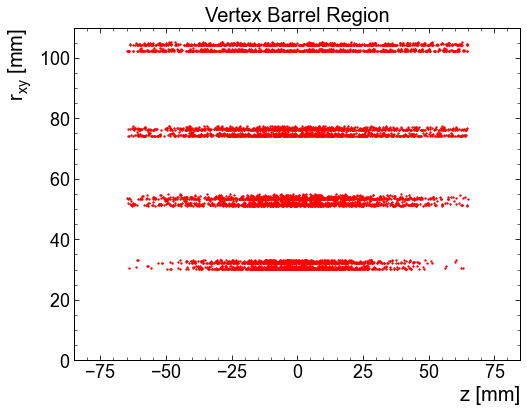

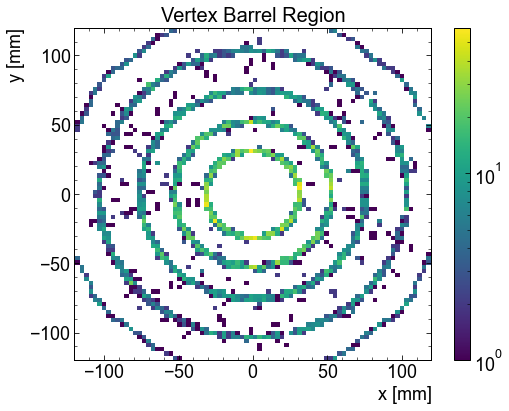

In [27]:
r_xy_vb, r_xyz_vb, vertex_layer = create_r_xy(which_data = nobib_134_1)
# print(r_xy_vb)

fig = plt.figure(figsize=(8,6))
#ax = fig.add_subplot(projection='3d')
limit = 85
limits = (-limit,limit)
#plt.scatter(ak.flatten(x),ak.flatten(y), label = 'bib', color = 'r', s = 3)
#plt.scatter(ak.flatten(run_14_nobib['x']),ak.flatten(run_14_nobib['y']), label = 'run_14_nobib', color = 'b', s = 15)
plt.scatter((r_xy_vb)[:,1], (r_xy_vb)[:,0], label = '', color = 'r', s = 3)
plt.xlim(limits)
plt.ylim(0, 110)
plt.xlabel('z [mm]', loc = 'right')
plt.ylabel(r'$r_{xy}$ [mm]', loc = 'top')
plt.title('Vertex Barrel Region')
#plt.legend()
plt.show()

plot2DHistogram((which_data['x']), (which_data['y']), bins=1000, label="Vertex Barrel Region;x [mm];y [mm]", xlim = (-120,120), ylim = (-120,120))

### Without Import

In [28]:
doublet_pairs_xyz, doublet_pairs_rz = find_doublets(r_xy_vb, r_xyz_vb, vertex_layer, num_hits = 1000)


Total pairs found from 1000 hits: 2613


<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
C:\Users\leoro\AppData\Local\Temp\ipykernel_42076\3088633994.py:4: SyntaxWarning: invalid escape sequence '\D'
  plot2DHistogram(d_theta_d_phi_134_1_nobib_staus[:,0]*1000, d_theta_d_phi_134_1_nobib_staus[:,1]*1000, bins=np.linspace(0,1,200), label="$\Delta \\theta$ vs. $\Delta \phi$; $\Delta \\theta$ [mrad];$\Delta \phi$ [mrad]")


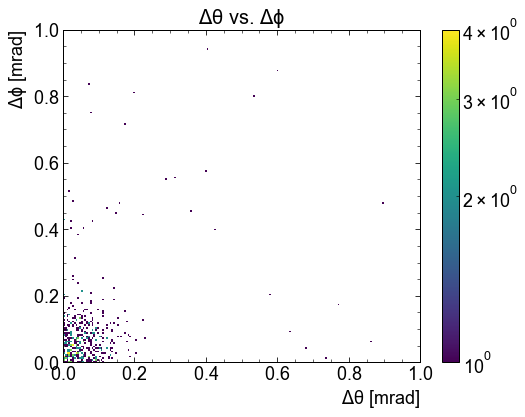

In [29]:
d_theta_d_phi_134_1_nobib_staus = pointing_angles(doublet_pairs_xyz)

# Plot the results with specified parameters
plot2DHistogram(d_theta_d_phi_134_1_nobib_staus[:,0]*1000, d_theta_d_phi_134_1_nobib_staus[:,1]*1000, bins=np.linspace(0,1,200), label="$\Delta \\theta$ vs. $\Delta \phi$; $\Delta \\theta$ [mrad];$\Delta \phi$ [mrad]")

<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
C:\Users\leoro\AppData\Local\Temp\ipykernel_42076\2647807695.py:5: SyntaxWarning: invalid escape sequence '\D'
  plot2DHistogram(d_theta_d_phi_134_1_nobib_staus[:,0]*1000, d_theta_d_phi_134_1_nobib_staus[:,1]*1000, bins=np.linspace(0,1,200), label="Staus; $\Delta \\theta$ [mrad];$\Delta \phi$ [mrad]")
C:\Users\leoro\AppData\Local\Temp\ipykernel_42076\2647807695.py:6: SyntaxWarning: invalid escape sequence '\D'
  plot2DHistogram(d_theta_d_phi_134_1_nobib_decay[:,0]*1000, d_theta_d_phi_134_1_nobib_decay[:,1]*1000, bins=np.linspace(0,1,200), label="Decay Products; $\Delta \\theta$ [mrad];$\Delta \phi$ [mrad]")


Duplicates found in dataset:
3
Total pairs found from 220 hits: 111
The hit survival rate: 0.29545454545454547


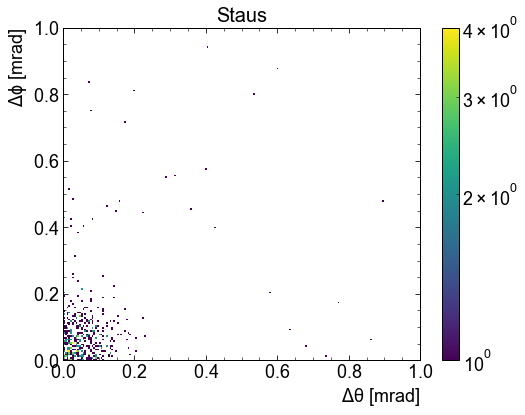

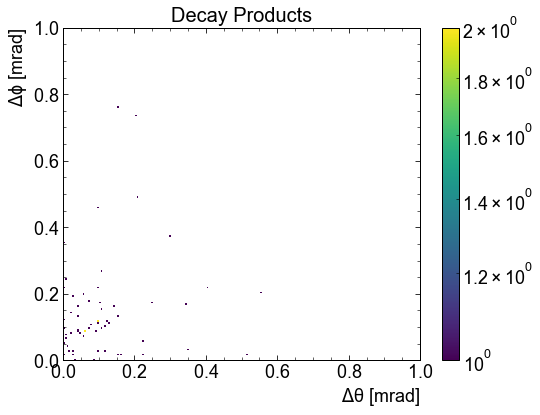

In [30]:

stau_kwargs = {'pt_cut': 100, 'd0_cut': 1, 'num_hits': None}
decay_kwargs = {'pt_cut': 1, 'd0_cut': 0.1, 'num_hits': None, 'decay': True} # Check that there is data for d0 > 1mm
# d_theta_d_phi_134_1_nobib_staus = all_pointing(nobib_134_1, **stau_kwargs)
d_theta_d_phi_134_1_nobib_decay = all_pointing(nobib_134_1, **decay_kwargs)
plot2DHistogram(d_theta_d_phi_134_1_nobib_staus[:,0]*1000, d_theta_d_phi_134_1_nobib_staus[:,1]*1000, bins=np.linspace(0,1,200), label="Staus; $\Delta \\theta$ [mrad];$\Delta \phi$ [mrad]")
plot2DHistogram(d_theta_d_phi_134_1_nobib_decay[:,0]*1000, d_theta_d_phi_134_1_nobib_decay[:,1]*1000, bins=np.linspace(0,1,200), label="Decay Products; $\Delta \\theta$ [mrad];$\Delta \phi$ [mrad]")


### Import d_theta_d_phi for > 10000 hits (see pointing_analysis.py)

<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\D'
C:\Users\leoro\AppData\Local\Temp\ipykernel_42076\2661086362.py:18: SyntaxWarning: invalid escape sequence '\D'
  plot2DHistogram(d_theta_d_phi_134_01_bib[:,0]*1000, d_theta_d_phi_134_01_bib[:,1]*1000, bins=np.linspace(0,1,200), label=f"{bib_title_134_01}; $\Delta \\theta$ [mrad];$\Delta \phi$ [mrad]")
C:\Users\leoro\AppData\Local\Temp\ipykernel_42076\2661086362.py:19: SyntaxWarning: invalid escape sequence '\D'
  plot2DHistogram(d_theta_d_phi_134_1_bib[:,0]*1000, d_theta_d_phi_134_1_bib[:,1]*1000, bins=np.linspace(0,1,200), label=f"{bib_title_134_1}; $\Delta \\theta$ [mrad];$\Delta \p

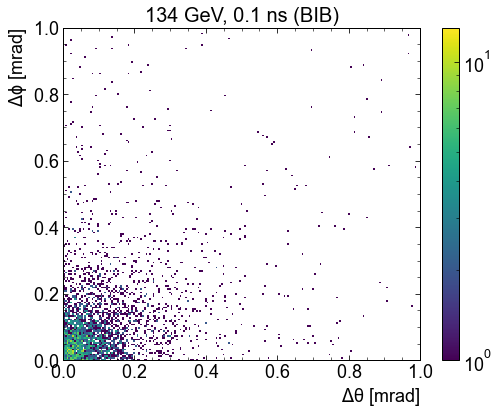

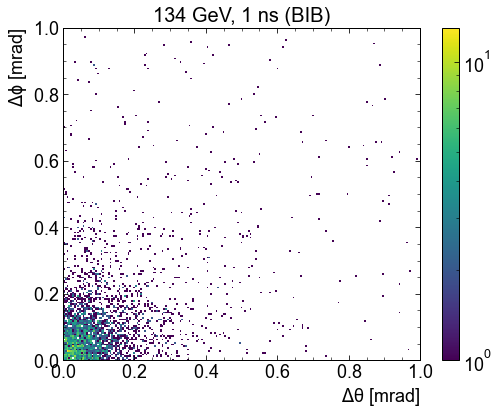

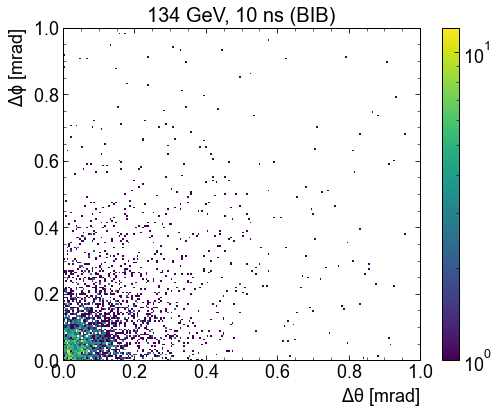

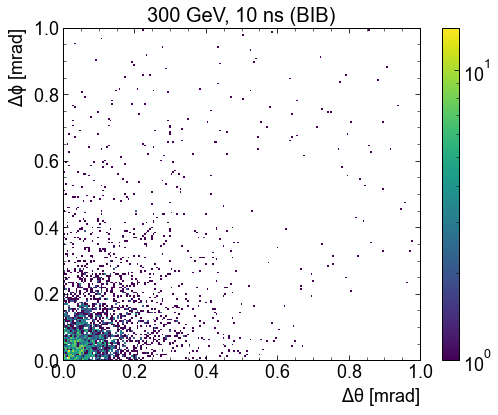

In [31]:
d_theta_d_phi_134_01_bib = np.load(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_0.1_d_theta_d_phi_bib.npy")
d_theta_d_phi_134_1_bib = np.load(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_1_d_theta_d_phi_bib.npy")
d_theta_d_phi_134_10_bib = np.load(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_10_d_theta_d_phi_bib.npy")
d_theta_d_phi_300_10_bib = np.load(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\300_10_d_theta_d_phi_bib.npy")
d_theta_d_phi_134_01 = np.load(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_0.1_d_theta_d_phi.npy")
d_theta_d_phi_134_1 = np.load(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_1_d_theta_d_phi.npy")
d_theta_d_phi_134_10 = np.load(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\134_10_d_theta_d_phi.npy")
d_theta_d_phi_300_10 = np.load(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\LLPs_data\300_10_d_theta_d_phi.npy")
bib_title_134_01 = "134 GeV, 0.1 ns (BIB)"
bib_title_134_1 = "134 GeV, 1 ns (BIB)"
bib_title_134_10 = "134 GeV, 10 ns (BIB)"
bib_title_300_10 = "300 GeV, 10 ns (BIB)"
title_134_01 = "134 GeV, 0.1 ns"
title_134_1 = "134 GeV, 1 ns"
title_134_10 = "134 GeV, 10 ns"
title_300_10 = "300 GeV, 10 ns"
# print(len(d_theta_d_phi_134_01_bib), len(d_theta_d_phi_134_1_bib), len(d_theta_d_phi_134_1_bib0), len(d_theta_d_phi_300_10_bib))
plot2DHistogram(d_theta_d_phi_134_01_bib[:,0]*1000, d_theta_d_phi_134_01_bib[:,1]*1000, bins=np.linspace(0,1,200), label=f"{bib_title_134_01}; $\Delta \\theta$ [mrad];$\Delta \phi$ [mrad]")
plot2DHistogram(d_theta_d_phi_134_1_bib[:,0]*1000, d_theta_d_phi_134_1_bib[:,1]*1000, bins=np.linspace(0,1,200), label=f"{bib_title_134_1}; $\Delta \\theta$ [mrad];$\Delta \phi$ [mrad]")
plot2DHistogram(d_theta_d_phi_134_10_bib[:,0]*1000, d_theta_d_phi_134_10_bib[:,1]*1000, bins=np.linspace(0,1,200), label=f"{bib_title_134_10}; $\Delta \\theta$ [mrad];$\Delta \phi$ [mrad]")
plot2DHistogram(d_theta_d_phi_300_10_bib[:,0]*1000, d_theta_d_phi_300_10_bib[:,1]*1000, bins=np.linspace(0,1,200), label=f"{bib_title_300_10}; $\Delta \\theta$ [mrad];$\Delta \phi$ [mrad]")


### BIB

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
C:\Users\leoro\AppData\Local\Temp\ipykernel_42076\4217913532.py:1: SyntaxWarning: invalid escape sequence '\D'
  compare1DHistograms([d_theta_d_phi_134_01_bib[:,0]*1000, d_theta_d_phi_134_1_bib[:,0]*1000, d_theta_d_phi_134_10_bib[:,0]*1000, d_theta_d_phi_300_10_bib[:,0]*1000], bins=100, scale='log', label="BIB; $\Delta \\theta$ [mrad];Count", leg=[title_134_01, title_134_1, title_134_10, title_300_10])
C:\Users\leoro\AppData\Local\Temp\ipykernel_42076\4217913532.py:2: SyntaxWarning: invalid escape sequence '\D'
  compare1DHistograms([d_theta_d_phi_134_01_bib[:,1]*1000, d_theta_d_phi_134_1_bib[:,1]*1000, d_theta_d_phi_134_10_bib[:,1]*1000, d_theta_d_phi_300_10_bib[:,1]*1000], bins=100, scale=

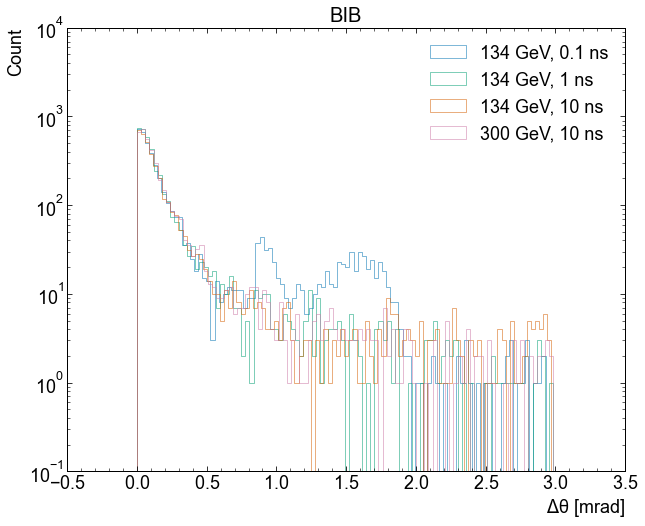

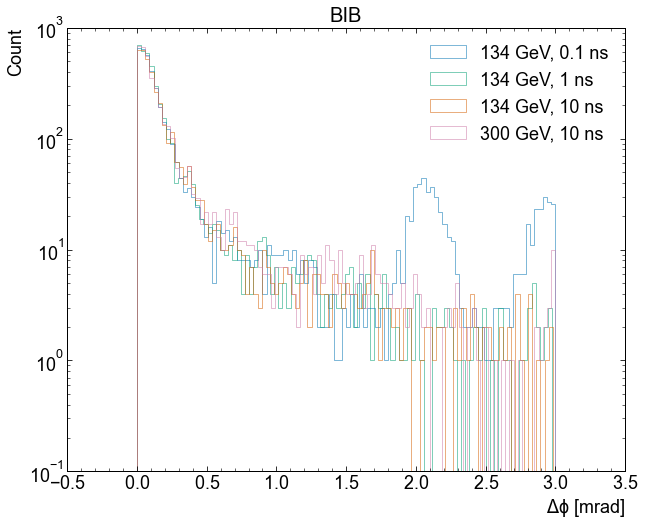

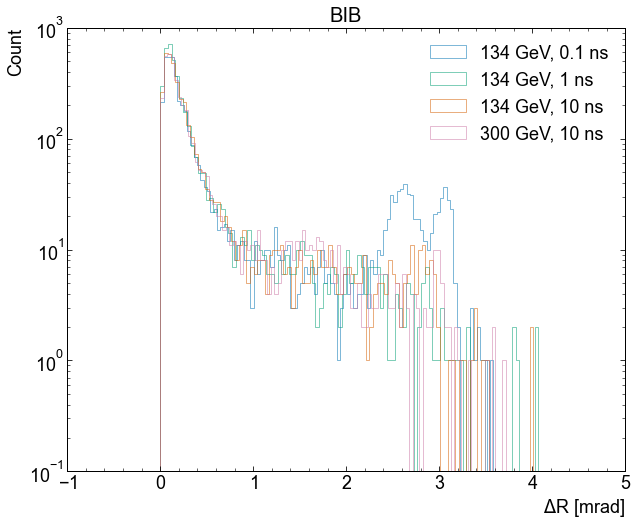

In [32]:
compare1DHistograms([d_theta_d_phi_134_01_bib[:,0]*1000, d_theta_d_phi_134_1_bib[:,0]*1000, d_theta_d_phi_134_10_bib[:,0]*1000, d_theta_d_phi_300_10_bib[:,0]*1000], bins=100, scale='log', label="BIB; $\Delta \\theta$ [mrad];Count", leg=[title_134_01, title_134_1, title_134_10, title_300_10])
compare1DHistograms([d_theta_d_phi_134_01_bib[:,1]*1000, d_theta_d_phi_134_1_bib[:,1]*1000, d_theta_d_phi_134_10_bib[:,1]*1000, d_theta_d_phi_300_10_bib[:,1]*1000], bins=100, scale='log', label="BIB; $\Delta \phi$ [mrad];Count", leg=[title_134_01, title_134_1, title_134_10, title_300_10])
dr_134_01_bib = np.sqrt((d_theta_d_phi_134_01_bib[:,0]*1000)**2 + (d_theta_d_phi_134_01_bib[:,1]*1000)**2)
dr_134_1_bib = np.sqrt((d_theta_d_phi_134_1_bib[:,0]*1000)**2 + (d_theta_d_phi_134_1_bib[:,1]*1000)**2)
dr_134_10_bib = np.sqrt((d_theta_d_phi_134_10_bib[:,0]*1000)**2 + (d_theta_d_phi_134_10_bib[:,1]*1000)**2)
dr_300_10_bib = np.sqrt((d_theta_d_phi_300_10_bib[:,0]*1000)**2 + (d_theta_d_phi_300_10_bib[:,1]*1000)**2)
compare1DHistograms([dr_134_01_bib, dr_134_1_bib, dr_134_10_bib, dr_300_10_bib], bins=100, scale='log', label="BIB; $\Delta R$ [mrad];Count", leg=[title_134_01, title_134_1, title_134_10, title_300_10])

### No BIB

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
C:\Users\leoro\AppData\Local\Temp\ipykernel_42076\1595203465.py:1: SyntaxWarning: invalid escape sequence '\D'
  compare1DHistograms([d_theta_d_phi_134_01[:,0]*1000, d_theta_d_phi_134_1[:,0]*1000, d_theta_d_phi_134_10[:,0]*1000, d_theta_d_phi_300_10[:,0]*1000], bins=100, scale='log', label="no BIB; $\Delta \\theta$ [mrad];Count", leg=[title_134_01, title_134_1, title_134_10, title_300_10])
C:\Users\leoro\AppData\Local\Temp\ipykernel_42076\1595203465.py:2: SyntaxWarning: invalid escape sequence '\D'
  compare1DHistograms([d_theta_d_phi_134_01[:,1]*1000, d_theta_d_phi_134_1[:,1]*1000, d_theta_d_phi_134_10[:,1]*1000, d_theta_d_phi_300_10[:,1]*1000], bins=100, scale='log', label="no BIB; $\Delta

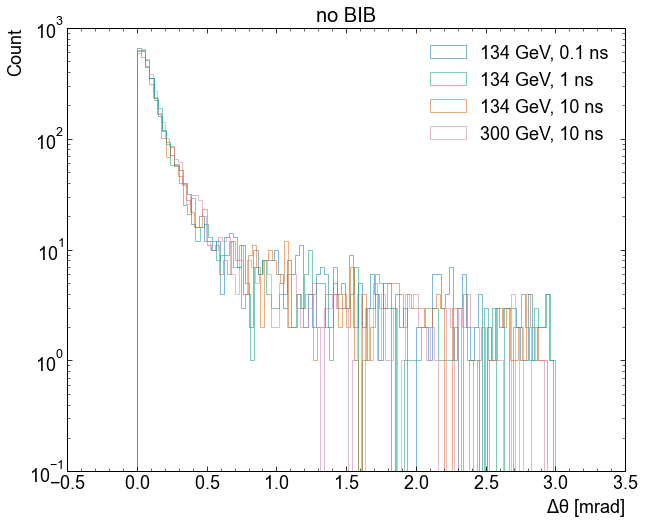

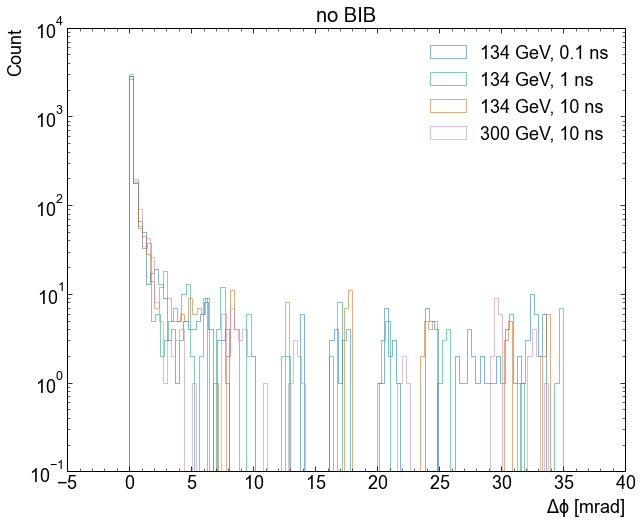

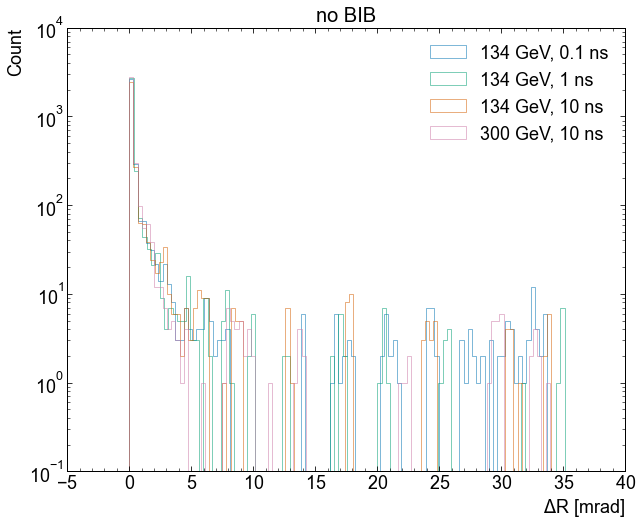

In [33]:
compare1DHistograms([d_theta_d_phi_134_01[:,0]*1000, d_theta_d_phi_134_1[:,0]*1000, d_theta_d_phi_134_10[:,0]*1000, d_theta_d_phi_300_10[:,0]*1000], bins=100, scale='log', label="no BIB; $\Delta \\theta$ [mrad];Count", leg=[title_134_01, title_134_1, title_134_10, title_300_10])
compare1DHistograms([d_theta_d_phi_134_01[:,1]*1000, d_theta_d_phi_134_1[:,1]*1000, d_theta_d_phi_134_10[:,1]*1000, d_theta_d_phi_300_10[:,1]*1000], bins=100, scale='log', label="no BIB; $\Delta \phi$ [mrad];Count", leg=[title_134_01, title_134_1, title_134_10, title_300_10])
dr_134_01 = np.sqrt((d_theta_d_phi_134_01[:,0]*1000)**2 + (d_theta_d_phi_134_01[:,1]*1000)**2)
dr_134_1 = np.sqrt((d_theta_d_phi_134_1[:,0]*1000)**2 + (d_theta_d_phi_134_1[:,1]*1000)**2)
dr_134_10 = np.sqrt((d_theta_d_phi_134_10[:,0]*1000)**2 + (d_theta_d_phi_134_10[:,1]*1000)**2)
dr_300_10 = np.sqrt((d_theta_d_phi_300_10[:,0]*1000)**2 + (d_theta_d_phi_300_10[:,1]*1000)**2)
compare1DHistograms([dr_134_01, dr_134_1, dr_134_10, dr_300_10], bins=100, scale='log', label="no BIB; $\Delta R$ [mrad];Count", leg=[title_134_01, title_134_1, title_134_10, title_300_10])

### Plot 2D Hists of $\eta$ vs $\phi$

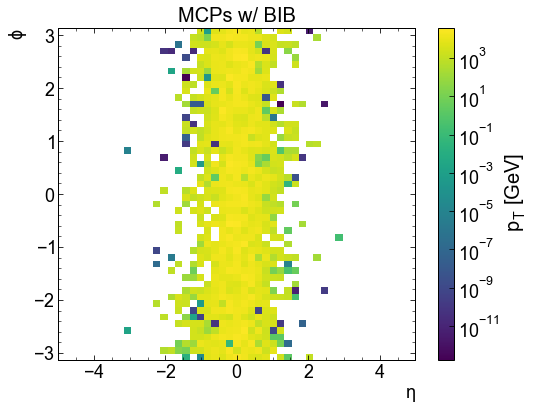

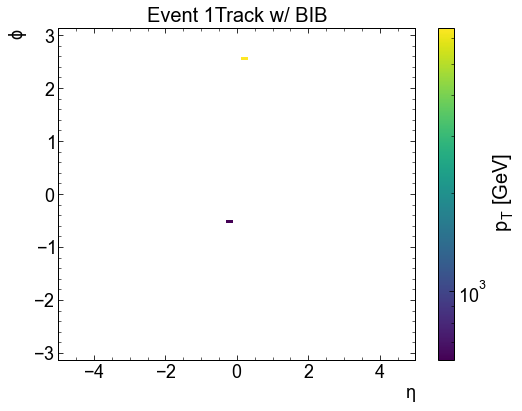

NameError: name 'nobib' is not defined

In [34]:
pt_250_1000 = [250,1000]
plot2DHistogram((mcp_eta[status == 1]), (mcp_phi[status == 1]), bins=(np.linspace(-5,5,50),50), weights = (mcp_pt[status == 1]), label=r"MCPs w/ BIB;$\eta$;$\phi$; $p_T$ [GeV]", xlim = (-5,5), ylim = (-3.14,3.14))

i = 0
while i < len(track_eta):
    plot2DHistogram((track_eta[i]), (track_phi[i]), bins=(np.linspace(-5,5,50),50 ), weights = (track_pt[i]), label=r"Event " + str(i+1) + r"Track w/ BIB;$\eta$;$\phi$; $p_T$ [GeV]", xlim = (-5,5), ylim = (-3.14,3.14))
    plot2DHistogram((nobib['track_eta'][i]), (nobib['track_phi'][i]), bins=(np.linspace(-5,5,50),50 ), weights = (nobib['track_pt'][i]), label=r"Event " + str(i+1) + r"Track w/o BIB;$\eta$;$\phi$; $p_T$ [GeV]", xlim = (-5,5), ylim = (-3.14,3.14))
    i+=1



### Misc. Studies

In [ ]:
print(len(ak.flatten(bib['track_pt'][bib['track_pt']<20]))/len(ak.flatten(bib['track_pt'])))
print(len(ak.flatten(nobib['track_pt'][nobib['track_pt']<20]))/len(ak.flatten(nobib['track_pt'])))

0.9259259259259259
0.0


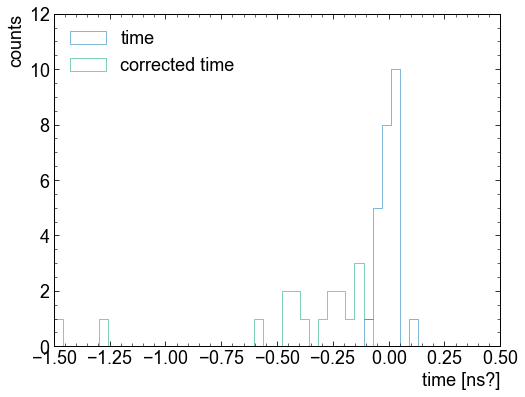

In [ ]:
fig = plt.figure(figsize=(8,6))
#ax = fig.add_subplot(projection='3d')
limits = (-1.5,0.5)
plt.hist(ak.flatten(nobib['time']), bins = np.linspace(limits[0],limits[1], 50), label = "time", histtype = 'step')
plt.hist(ak.flatten(nobib['corrected_time']), bins = np.linspace(limits[0],limits[1], 50), label = "corrected time", histtype = 'step')
plt.xlim(limits)
#plt.ylim(limits)
plt.xlabel('time [ns?]', loc = 'right')
plt.ylabel('counts', loc = 'top')
plt.legend()
plt.show()

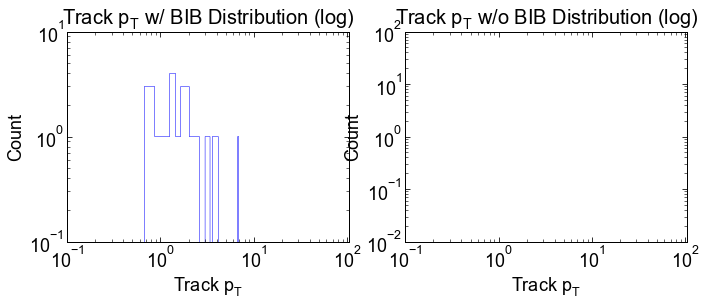

In [ ]:
# Histogram for track pt
plt.subplot(2, 2, 1)
plt.hist(ak.flatten(bib['track_pt']), bins=1000, color='blue', histtype = 'step')
plt.xlim(0.1,105)
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ w/ BIB Distribution (log)')
plt.yscale('log')
plt.xscale('log')


plt.subplot(2, 2, 2)
plt.hist(ak.flatten(nobib['track_pt']), bins=1000, color='blue', histtype = 'step')
plt.xlim(0.1,105)
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ w/o BIB Distribution (log)')
plt.yscale('log')
plt.xscale('log')
